In [1]:
import os
import sys
import math
import gc

from copy import deepcopy

import numpy as np
import pandas as pd

import seaborn as sns

from scipy.spatial.distance import pdist, squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
device = None
os.environ["CUDA_VISIBLE_DEVICES"]="5"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    use_cuda = True

# Ignore cuda
use_cuda = False
device = None

# Set DoubleTensor as a base type for computations
t_type = torch.float64

In [2]:
%load_ext line_profiler

In [3]:
def pairwise_diffs(x, y):    
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: diffs is a NxM matrix where diffs[i,j] is the subtraaction between x[i,:] and y[j,:]
    i.e. diffs[i,j] = x[i,:]-y[j,:]
    '''
    return x[:,np.newaxis,:] - y[np.newaxis,:,:]

In [4]:
def pairwise_dists(x=None, y=None, diffs=None):
    '''
    Input: pairwise diffs is a MxN matrix where diffs[i,j] = x[i,:] - y[j, :]
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    return torch.norm(diffs, dim=2)

In [5]:
class normal_density():
    def __init__(self, n=None, mu=None, std=None):
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.mu = torch.tensor(mu, dtype=t_type, device=device)
        self.std = torch.tensor(std, dtype=t_type, device=device)
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.pi = torch.tensor(math.pi, dtype=t_type, device=device)
        
        if not n:
            self.n = torch.tensor(1., dtype=t_type, device=device)
        if not mu:
            self.mu = torch.tensor(0., dtype=t_type, device=device)
        if not std:
            self.std = torch.tensor(1., dtype=t_type, device=device)

    def __call__(self, x):
        return (torch.pow(self.two * self.pi, -self.n / self.two) * 
                torch.pow(self.std, -self.n) * 
                torch.exp(-self.one / (self.two * self.std * self.std) * torch.sum(torch.pow(x - self.mu, self.two))))
    
    def unnormed_density(self, x):
        return torch.exp(-self.one / (self.two * self.std * self.std) * torch.sum(torch.pow(x - self.mu, self.two)))

In [6]:
class SteinLinear(nn.Module):
    def __init__(self, in_features, out_features, n_particles=1, bias=True):
        super(SteinLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_particles = n_particles
        
        self.weight = torch.nn.Parameter(torch.zeros([n_particles, in_features, out_features], dtype=t_type))
        
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros([n_particles, 1, out_features], dtype=t_type))
        else:
            self.register_parameter('bias', None)
            
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(2))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            
    def forward(self, X):
        return torch.matmul(X, self.weight) + self.bias

In [7]:
arc = nn.Sequential(
    SteinLinear(10, 5, 10),
    nn.LeakyReLU(),
    SteinLinear(5, 4, 10),
    nn.LeakyReLU(),
    SteinLinear(4, 1, 10)
)

In [8]:
class SteinNet():
    def __init__(self, arc, train_size):
        '''
        p(y|x,w) = N(y|f(x,w), alpha^-1)
        p0(w) = N(w|0, betta^-1)
        
        k(w, w`) = exp^(-1/h * ||w - w`||^2)
        '''
        
        ### f(x, w)
        self.arc = arc
        if use_cuda:
            self.arc = self.arc.cuda()
            
        ### n_particles
        self.n_particles = arc[0].n_particles
        
        self.train_size = train_size
        
        ### variances from probabilistic model
        self.alpha = torch.tensor(1., dtype=t_type)
        self.betta = torch.tensor(1., dtype=t_type)
        if use_cuda:
            self.alpha = self.alpha.cuda()
            self.betta = self.betta.cuda()
            
        ### factor from kernel
        self.h = torch.tensor(1., dtype=t_type)
        if use_cuda:
            self.h = self.h.cuda()
    
    ### SUM for all j {log p(Dj|w)}
    ### return tensor [n_particles]
    def calc_data_term(self, X, y):
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            two = two.cuda()
        
        X = X.view(1, *X.shape).expand(self.n_particles, *X.shape)
        y_p = self.arc(X).view(self.n_particles, X.shape[1])
        
        return -(torch.pow(self.alpha, two) / two) * torch.mean(torch.pow(y - y_p, two), dim=1) * self.train_size
    
    ### log p0(w)
    ### return tensor [n_particles] 
    def calc_prior_term(self):
        result = torch.zeros([self.n_particles])
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            result = result.cuda()
            two = two.cuda()
            
        for name, param in self.arc.named_parameters():
            log_p0 = -(torch.pow(self.betta, two) / two) * torch.pow(param, two)
            result += torch.sum(log_p0.view(param.shape[0], -1), dim=1)
        return result
    
    ### k(w, w)
    ### return tensor [n_particles, n_particles]
    def calc_kernel_term(self):
        one = torch.tensor(1., dtype=t_type)
        distances = torch.zeros([self.n_particles, self.n_particles])
        if use_cuda:
            one = one.cuda()
            distances = distances.cuda()
        
        for name, param in self.arc.named_parameters():
            distances += pairwise_distances(param.view(self.n_particles, -1), param.view(self.n_particles, -1))
            
        return torch.exp(-one / self.h * distances)
    
    def update(self, X, y):
        two = torch.tensor(2., dtype=t_type)
        if use_cuda:
            two = two.cuda()
            
        prior = self.calc_prior_term
        data = self.calc_data_term
        kernel = self.calc_kernel_term
        
        log_term = prior + data
        log_term.backward()
        
        for name, param in self.arc.named_parameters():
            update_term = torch.zeros_like(param)
            
            #update_term += - two / self.h * kernel[]

In [9]:
# #X = torch.Tensor([[1, 2, 3], [2, 2, 2], [4, 3, 2]]).cuda()
# X = torch.rand([20, 10]).cuda()
# # y = torch.Tensor([1, 1, 1]).cuda()
# y = torch.rand([20]).cuda()

In [10]:
# s = SteinNet(arc, 1000)

In [11]:
# s.calc_prior_term()

In [12]:
# s.calc_data_term(X, y)

In [13]:
# s.calc_kernel_term()

In [14]:
class DistributionMover():
    def __init__(self, particles=None, n_particles=None, n_dims=None, n_hidden_dims=None, use_latent=False, target_density=None):
        if not particles and not n_particles:
            raise RuntimeError
        
        self.particles = particles
        
        self.n_particles = n_particles
        self.N = None
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_latent = use_latent
        
        self.target_density=target_density
        self.real_target_density=None
        
        self.A = None
        self.A_i = None
        self.tetta_0 = None
        
        if not self.use_latent:
            self.n_hidden_dims = self.n_dims
        
        if particles:
            self.n_particles = particles.shape[0]
        else:
            self.particles = torch.zeros([n_particles, self.n_hidden_dims], dtype=t_type,
                                         requires_grad=False, device=device).uniform_(-2, -1)
        self.N = torch.tensor(self.n_particles, dtype=t_type, device=device)
        
        if self.use_latent:
            self.A = torch.zeros([self.n_hidden_dims, self.n_dims], dtype=t_type, device=device).uniform_(-1., 1.)
            self.A_i = torch.pinverse(self.A)
            self.tetta_0 = torch.zeros([self.n_particles, self.n_dims], dtype=t_type, device=device)#.uniform_(-1.,1.)
            
        ### Function of probability density of target distribution
        if target_density:
            self.target_density = target_density
        else:    
            # use unnormed probability density to speedup computations
            self.target_density = lambda x : (0.3 * normal_density(self.n_dims, -2., 1.).unnormed_density(x) + 
                                              0.7 * normal_density(self.n_dims, 2., 1.).unnormed_density(x))
            
            self.real_target_density = lambda x : (0.3 * normal_density(self.n_dims, -2., 1.)(x) + 
                                                   0.7 * normal_density(self.n_dims, 2., 1.)(x))

#             self.target_density = lambda x : (normal_density(self.n_dims, 0., 2.).unnormed_density(x))
            
#             self.real_target_density = lambda x : (normal_density(self.n_dims, 0., 2.)(x))
        
        ### Number of iterations since begining
        self.iter = 0
        
        ### Adagrad parameters
        self.fudge_factor = torch.tensor(1e-6, dtype=t_type, device=device)
        self.step_size = torch.tensor(1e-2, dtype=t_type, device=device)
        self.auto_corr = torch.tensor(0.9, dtype=t_type, device=device)
        
        ### Gradient history term for adagrad optimization 
        self.historical_grad = torch.zeros_like(self.particles, device=device)
        
        ### Factor from kernel
        self.med = torch.tensor(0., dtype=t_type, device=device)
        self.h = torch.tensor(0., dtype=t_type, device=device)
          
        ### Support tensors for computations 
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
    
    ### k(w, w)
    ### return tensor [n_particles, n_particles]
    def calc_kernel_term(self, h_type):
        diffs = pairwise_diffs(self.particles, self.particles)
            
        dists = pairwise_dists(diffs=diffs)
        sq_dists = torch.pow(dists, self.two)
    
        ### RBF Kernel
        if h_type == 0:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1)  
        elif h_type == 1:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (self.n_hidden_dims) 
        elif h_type == 2:
            self.med = torch.median(sq_dists) + self.fudge_factor
            self.h = self.med / torch.log(self.N + 1) * (2. * self.n_hidden_dims)
        elif h_type == 3:
            self.var  = torch.var(self.particles) + self.fudge_factor
            self.h =  self.var / torch.log(self.N + 1.) * (2. * self.n_hidden_dims)
        elif h_type == 4:
            self.var = torch.var(diffs) + self.fudge_factor
            self.h = self.var / torch.log(self.N + 1) * (self.n_hidden_dims)
        elif type(h_type) == float:
            self.h = h_type
        
        kernel = torch.exp(-self.one / self.h * sq_dists)
        
        grad_kernel = -self.two / self.h * kernel.unsqueeze(dim=2) * diffs

        return kernel, -grad_kernel
    
    def calc_log_term(self):
#        grad_log_term = torch.zeros([self.n_particles, self.n_dims], dtype=t_type, device=device)
        grad_log_term = torch.zeros([self.n_particles, self.n_hidden_dims], dtype=t_type, device=device)
        
        if self.use_latent:
#             for idx in range(self.n_particles):
#                 particle = torch.tensor(self.particles[idx], dtype=t_type, requires_grad=True, device=device)
#                 particle_real = self.tetta_0[idx] + torch.matmul(particle, self.A)
#                 log_term = torch.log(self.target_density(particle_real))
#                 grad_log_term[idx] = torch.autograd.grad(log_term, particle,
#                                                          only_inputs=True, retain_graph=False, 
#                                                          create_graph=False, allow_unused=False)[0]
                
#             return torch.matmul(grad_log_term, torch.t(self.A_i))
            for idx in range(self.n_particles):
                particle = torch.tensor(self.particles[idx], dtype=t_type, requires_grad=True, device=device)
                particle_real = self.tetta_0[idx] + torch.matmul(particle, self.A)
                log_term = torch.log(self.target_density(particle_real))
                grad_log_term[idx] = torch.autograd.grad(log_term, particle_real,
                                                         only_inputs=True, retain_graph=False, 
                                                         create_graph=False, allow_unused=False)[0]
                
            return grad_log_term
        
        else:
            for idx in range(self.n_particles):
                particle = torch.tensor(self.particles[idx], dtype=t_type, requires_grad=True, device=device)
                log_term = torch.log(self.target_density(particle))
                grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                         only_inputs=True, retain_graph=False, 
                                                         create_graph=False, allow_unused=False)[0]
                
            return grad_log_term
        
    def update(self, h_type):
        self.iter += 1
        
        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term(h_type)
        grad_log_term = self.calc_log_term()
        
        ### Compute value of step in functiuonal space
        phi = (torch.matmul(kernel.t(), grad_log_term) + torch.sum(grad_kernel, dim=1)) / self.N
        if self.use_latent:
            phi = torch.matmul(phi, self.A_i)
                            
        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi
            
        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
        

In [15]:
dm = DistributionMover(n_particles=100, n_dims=2, n_hidden_dims=2, use_latent=False)

In [16]:
#marginal_density = lambda x : (normal_density(mu=0, std=2, n=1)(x))
marginal_density = lambda x : (0.3 * normal_density(mu=-2, std=1, n=1)(x) + 0.7 * normal_density(mu=2, std=1, n=1)(x))

pdf = []
for _ in np.linspace(-10, 10, 1000): 
    _ = torch.tensor(_, dtype=t_type, device=device)
    pdf.append(marginal_density(_))
    
from pynverse import inversefunc
from scipy.interpolate import interp1d
from scipy.integrate import quad
cum_density = interp1d(np.linspace(-20, 20, 5000), [quad(marginal_density, -20, x)[0] for x in np.linspace(-20, 20, 5000)])
inv_cum_density = inversefunc(cum_density)
real_samples = [inv_cum_density(np.random.random()) for x in range(1000)]

In [17]:
mean = quad(lambda x : marginal_density(x) * x, -20, 20)[0]
var = quad(lambda x : marginal_density(x) * (x - mean) ** 2, -20, 20)[0]

In [18]:
mean, var

(0.7999999999999998, 4.359999999999999)

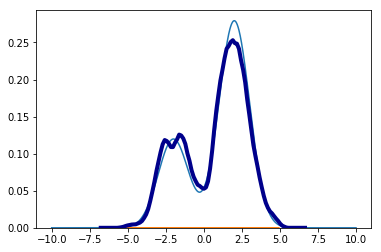

In [19]:
plt.plot(np.linspace(-10, 10, 1000), pdf)
plt.plot(real_samples, np.zeros_like(real_samples))
sns.kdeplot(real_samples, kernel='tri', color='darkblue', linewidth=4)

In [20]:
def plot_projections(dm=None, use_real=True, kernel='tri'):
    N_plots = None
    scale_factor = None
    
    if use_real:
        if not dm.use_latent:
            return
        N_plots = dm.A.shape[1]
    else:
        N_plots = dm.particles.shape[1]
    if N_plots > 6:
        scale_factor = 15
    else:
        scale_factor = 5
        
    N_plots = min(N_plots, 12)
        
    plt.figure(figsize=(3 * scale_factor, (N_plots // 3 + 1) * scale_factor))
    
    for idx in range(N_plots):
        slice_dim = idx
        
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        
        particles = None
        if use_real:
            particles = (dm.tetta_0 + torch.matmul(dm.particles, dm.A))[:, slice_dim]
        else:
            particles = dm.particles[:, slice_dim]
        
        plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
        plt.plot(particles.data.cpu().numpy(), torch.zeros_like(particles).data.cpu().numpy(), 'ro')
        sns.kdeplot(particles.data.cpu().numpy(), 
                    kernel=kernel, color='darkblue', linewidth=4)

In [21]:
plot_projections(dm, use_real=True)

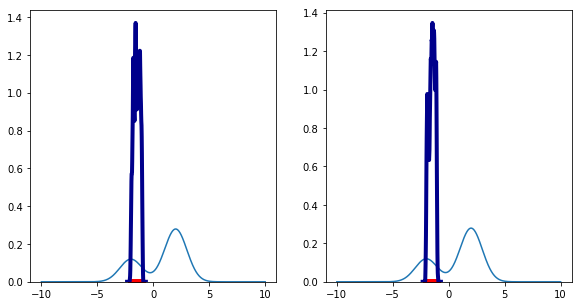

In [22]:
plot_projections(dm, use_real=False)

In [23]:
# disps = []

In [ ]:
dm = DistributionMover(n_particles=100, n_dims=20, n_hidden_dims=2, use_latent=False)

In [ ]:
%%time

from IPython.display import clear_output

for __ in range(1):
    #dm = DistributionMover(n_particles=100, n_dims=__, n_hidden_dims=2, use_latent=False)
    for _ in range(3000): 
        try:
            dm.update(h_type=1e3)

            if _ % 100 == 0:
                clear_output()
                sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

                plot_projections(dm, use_real=True, kernel='tri')
                plot_projections(dm, use_real=False, kernel='tri')

                plt.pause(1e-300)

        except KeyboardInterrupt:
            break
    #d = torch.mean(torch.std(dm.particles, dim=0) ** 2).data.cpu().numpy()
    #disps.append(d)

In [ ]:
dm.h # +

In [ ]:
dm.h # +-

In [ ]:
dm.h # +

In [ ]:
dm.h # +-

In [ ]:
dm.h # +

In [ ]:
torch.mean(torch.mean(dm.particles, dim=0)), torch.mean(torch.std(dm.particles, dim=0) ** 2)

In [ ]:
# #real_particles = (dm.tetta_0 + torch.matmul(dm.particles, dm.A))
# real_particles = dm.particles
# sns.kdeplot(real_particles[:,(0,1)].data.cpu().numpy(), 
#             kernel='tri', color='darkblue', linewidth=4)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 3, 0.025)
Y = np.arange(-1, 3, 0.025)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
XY = torch.stack([torch.tensor(X, dtype=t_type), torch.tensor(Y, dtype=t_type)], dim=2)
Z = torch.zeros([XY.shape[0], XY.shape[1]])
for idx in range(XY.shape[0]):
    for jdx in range(XY.shape[1]):
        Z[idx, jdx] = (0.3 * normal_density(mu=0, std=1, n=2)(XY[idx, jdx]) + 
                       0.7 * normal_density(mu=2, std=1, n=2)(XY[idx, jdx]))
Z = Z.cpu().data.numpy()
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [45]:
sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
from svgd import SVGD

In [46]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, use_latent=False)

In [47]:
dm_svgd = SVGD()

In [48]:
def lnprob(particles):
    grad_log_term = torch.zeros(particles.shape, dtype=t_type, device=device)
        
    for idx in range(particles.shape[0]):
        particle = torch.tensor(particles[idx], dtype=t_type, requires_grad=True, device=device)
        log_term = torch.log(dm.target_density(particle))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                     only_inputs=True, retain_graph=False, 
                                                     create_graph=False, allow_unused=False)[0]
    return grad_log_term

In [49]:
result = dm_ex.particles

In [50]:
for _ in range(1):
    print(_)
    result = dm_svgd.update(result, lnprob, stepsize=1e-1, bandwidth=1e-3)
    result = torch.tensor(result, dtype=t_type)

0


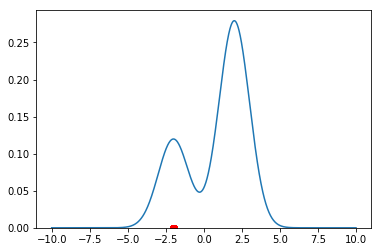

In [51]:
plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
sns.kdeplot(result.data.cpu().numpy()[:, 2], 
            kernel='tri', color='darkblue', linewidth=4)

In [52]:
sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
from svgd import SVGD

In [53]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, use_latent=False)

In [54]:
dm_svgd = SVGD()

In [55]:
def lnprob(particles):
    grad_log_term = torch.zeros(particles.shape, dtype=t_type, device=device)
        
    for idx in range(particles.shape[0]):
        particle = torch.tensor(particles[idx], dtype=t_type, requires_grad=True, device=device)
        log_term = torch.log(dm.target_density(particle))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                     only_inputs=True, retain_graph=False, 
                                                     create_graph=False, allow_unused=False)[0]
    return grad_log_term

In [56]:
result = dm_ex.particles

In [57]:
for _ in range(1):
    print(_)
    result = dm_svgd.update(result, lnprob, stepsize=1e-1, bandwidth=1e3)
    result = torch.tensor(result, dtype=t_type)

0


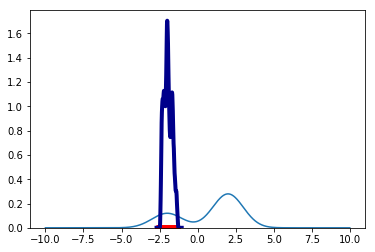

In [58]:
plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
sns.kdeplot(result.data.cpu().numpy()[:, 2], 
            kernel='tri', color='darkblue', linewidth=4)

In [59]:
sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
from svgd import SVGD

In [60]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, use_latent=False)

In [61]:
dm_svgd = SVGD()

In [62]:
def lnprob(particles):
    grad_log_term = torch.zeros(particles.shape, dtype=t_type, device=device)
        
    for idx in range(particles.shape[0]):
        particle = torch.tensor(particles[idx], dtype=t_type, requires_grad=True, device=device)
        log_term = torch.log(dm.target_density(particle))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                     only_inputs=True, retain_graph=False, 
                                                     create_graph=False, allow_unused=False)[0]
    return grad_log_term

In [63]:
result = dm_ex.particles

In [64]:
for _ in range(1):
    print(_)
    result = dm_svgd.update(result, lnprob, stepsize=1e-1, bandwidth=1.)
    result = torch.tensor(result, dtype=t_type)

0


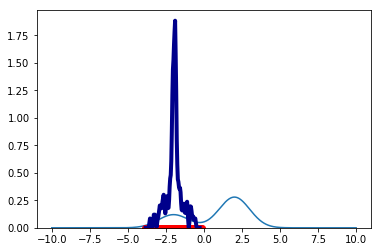

In [65]:
plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
sns.kdeplot(result.data.cpu().numpy()[:, 2], 
            kernel='tri', color='darkblue', linewidth=4)